In [44]:
#필요한 라이브러리 다운로드
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split#데이터 분할
from sklearn.model_selection import GridSearchCV #교차검증
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_predict,cross_validate
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from joblib import Parallel, parallel_backend
import seaborn as sns
import matplotlib.pyplot as plt



df = pd.read_csv(r"C:\Users\Administrator\Desktop\end_hotel_bookings.csv") #데이터 불러오기
#종속변수와 독립변수 나누기
X = df.drop('is_canceled', axis = 1).copy()
y = df['is_canceled'].copy()
#train 데이터와 test데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)


xgboost 기본 모델 실행

In [13]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

model =XGBClassifier()
score = cross_validate(model, X, y,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.8883056412483012
Test Accuracy: 0.871368865991647
Train Precision: 0.873365132200934
Test Precision: 0.850490651411481
Train Recall: 0.818981235818453
Test Recall: 0.7944466946903915
Train F1: 0.8452991576236546
Test F1: 0.8215065435374846


gridsearch를 통한 최적의 하이퍼파라미터값 찾기

In [50]:
param_grid = {
    'n_estimators':[100,300],
    'max_depth': [8,9],# 트리의 최대 깊이. 클수록 모델이 더 복잡해지고 과적합의 위험
    'min_child_weight':[3,5,7],#작은 값은 과적합을 유발할 수 있으며, 높은 값은 더 많은 제약을 줄 수 있습니다.
    'learning_rate': [0.3,0.1,0.01],  # 학습률 (eta). 각 부스팅 단계에서 가중치를 얼마나 줄일지 결정. 작을수록 모델 학습이 더 천천히 이루어짐.
    'gamma': [0.7, 0.9, 1.1],  # 노드 분할을 위해 필요한 최소 손실 감소. 클수록 모델이 더 보수적.
    'colsample_bytree': [0.5, 0.7, 0.9],  # 이 값이 낮을수록 각 트리는 더 간단해지지만, 너무 낮으면 모델의 성능이 저하될 수 있습니다.
    'subsample': [0.5,0.7,0.9]  # 이 값이 높을수록 더 보수적으로 가지가 나뉩니다.
    
}
#Best parameters found:  {'gamma': 0.9, 'learning_rate': 0.3, 'max_depth': 7, 'reg_lambda': 0.8, 'scale_pos_weight': 3}
# GridSearchCV 실행
optimal_param = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                             param_grid=param_grid,
                             scoring='roc_auc',
                             verbose=2,
                             n_jobs=10,
                             cv=5)



# tqdm을 사용한 진행 상황 모니터링
def tqdm_parallel_backend():
    class TQDMParallel(Parallel):
        def __call__(self, *args, **kwargs):
            with tqdm(total=self.n_jobs) as self._pbar:
                return super().__call__(*args, **kwargs)

        def print_progress(self):
            if self._pbar is not None:
                self._pbar.n = self.n_completed_tasks
                self._pbar.refresh()
    
    return TQDMParallel(n_jobs=optimal_param.n_jobs)

with parallel_backend('threading', n_jobs=optimal_param.n_jobs):
    optimal_param.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = optimal_param.best_params_
print("Best parameters found: ", best_params)
print("Best ROC AUC score: ", optimal_param.best_score_)



Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   2.9s
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   3.0s
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   3.0s
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   3.1s
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   3.1s
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.5, gamma=0.7, learning_rate=0.3,

TypeError: xgboost.sklearn.XGBClassifier() got multiple values for keyword argument 'colsample_bytree'

최적의 xgboost 재실행

In [12]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
#Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

model =XGBClassifier(colsample_bytree = 0.9, gamma = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 3, n_estimators = 300, subsample = 0.9)
score = cross_validate(model, X, y,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.9259356012221526
Test Accuracy: 0.8826232489956645
Train Precision: 0.9186234375625467
Test Precision: 0.863368788222654
Train Recall: 0.8791004600755782
Test Recall: 0.8138009461911068
Train F1: 0.8984264421214221
Test F1: 0.8378333521626142


ROC 커브값 출력

svd_standard 기본모델 사용

In [2]:
df_svd_standard = pd.read_csv(r"C:\Users\Administrator\Desktop\SVD_Standard.csv")
X_standard = df_svd_standard.drop('is_canceled', axis = 1).copy()
y_standard = df_svd_standard['is_canceled'].copy()
#train 데이터와 test데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_standard, y_standard,test_size=0.2, random_state=42)

In [14]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

model =XGBClassifier()
score = cross_validate(model, X_standard, y_standard,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.9063551107501514
Test Accuracy: 0.8569462905642222
Train Precision: 0.9106397555497612
Test Precision: 0.8469222752388488
Train Recall: 0.8301342734258039
Test Recall: 0.7520003753980127
Train F1: 0.8685243871854131
Test F1: 0.7966239609669175


In [3]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
#Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

model =XGBClassifier(colsample_bytree = 0.9, gamma = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 3, n_estimators = 300, subsample = 0.9)
score = cross_validate(model, X_standard, y_standard,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.9820991750494242
Test Accuracy: 0.8728552942350442
Train Precision: 0.9850115363886294
Test Precision: 0.8634479869838151
Train Recall: 0.966666287795665
Test Recall: 0.7825698971586647
Train F1: 0.9757525938520327
Test F1: 0.8209889957177753


SVD_Standard Grid Search 진행

In [17]:
param_grid = {
    'n_estimators':[100,300,500],
    'max_depth': [8,9,10],# 트리의 최대 깊이. 클수록 모델이 더 복잡해지고 과적합의 위험
    # 'min_child_weight':[3,5,7],#작은 값은 과적합을 유발할 수 있으며, 높은 값은 더 많은 제약을 줄 수 있습니다.
    'learning_rate': [0.3,0.1,0.01],  # 학습률 (eta). 각 부스팅 단계에서 가중치를 얼마나 줄일지 결정. 작을수록 모델 학습이 더 천천히 이루어짐.
    # 'gamma': [0.7, 0.9, 1.1],  # 노드 분할을 위해 필요한 최소 손실 감소. 클수록 모델이 더 보수적.
    # 'colsample_bytree': [0.5, 0.7, 0.9],  # 이 값이 낮을수록 각 트리는 더 간단해지지만, 너무 낮으면 모델의 성능이 저하될 수 있습니다.
    # 'subsample': [0.5,0.7,0.9]  # 이 값이 높을수록 더 보수적으로 가지가 나뉩니다.
    
}
#Best parameters found:  {'gamma': 0.9, 'learning_rate': 0.3, 'max_depth': 7, 'reg_lambda': 0.8, 'scale_pos_weight': 3}
# GridSearchCV 실행
optimal_param = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                             param_grid=param_grid,
                             scoring='roc_auc',
                             verbose=2,
                             n_jobs=10,
                             cv=5)



# tqdm을 사용한 진행 상황 모니터링
def tqdm_parallel_backend():
    class TQDMParallel(Parallel):
        def __call__(self, *args, **kwargs):
            with tqdm(total=self.n_jobs) as self._pbar:
                return super().__call__(*args, **kwargs)

        def print_progress(self):
            if self._pbar is not None:
                self._pbar.n = self.n_completed_tasks
                self._pbar.refresh()
    
    return TQDMParallel(n_jobs=optimal_param.n_jobs)

with parallel_backend('threading', n_jobs=optimal_param.n_jobs):
    optimal_param.fit(X_standard, y_standard)

# 최적의 하이퍼파라미터 출력
best_params = optimal_param.best_params_
print("Best parameters found: ", best_params)
print("Best ROC AUC score: ", optimal_param.best_score_)



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=   6.2s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=   6.2s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=   6.2s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=   7.1s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=100; total time=   7.2s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  18.6s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  18.7s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  19.1s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  20.6s
[CV] END ...learning_rate=0.3, max_depth=7, n_estimators=300; total time=  21.2s
[CV] END ...learning_rate=0.3, max_depth=8, n_estimators=100; total time=  13.0s
[CV] END ...learning_rate=0.3, max_depth=8, n_e

svd를 진행한 데이터에도 그리드 서치를 진행했지만 결과값이 오히려 좋지 않게 나와 하이퍼파라미터는 기본 데이터를 그리드 서치한 기준으로 결정

In [20]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
#Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

model =XGBClassifier(colsample_bytree = 0.9, gamma = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 3, n_estimators = 300, subsample = 0.9)
score = cross_validate(model, X_standard, y_standard,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.9820524579624197
Test Accuracy: 0.8720568762516713
Train Precision: 0.9849307741609202
Test Precision: 0.8618279804475119
Train Recall: 0.9666206933582602
Test Recall: 0.7820000524330833
Train F1: 0.9756897454183548
Test F1: 0.8199693031518491


minmax데이터 기본 모델

In [6]:
df_svd_minmax = pd.read_csv(r"C:\Users\Administrator\Desktop\SVD_Minmax.csv")
X_minmax = df_svd_minmax.drop('is_canceled', axis = 1).copy()
y_minmax = df_svd_minmax['is_canceled'].copy()
#train 데이터와 test데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y_minmax,test_size=0.2, random_state=42)

In [21]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

model =XGBClassifier()
score = cross_validate(model, X_minmax, y_minmax,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.8555065729283073
Test Accuracy: 0.8189192147628672
Train Precision: 0.8606269358270193
Test Precision: 0.8064620347734976
Train Recall: 0.730509260066054
Test Recall: 0.6763170077203167
Train F1: 0.7902462466035631
Test F1: 0.735672163549727


minmax데이터 최적 하이퍼파라미터 진행

In [7]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
#Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

model =XGBClassifier(colsample_bytree = 0.9, gamma = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 3, n_estimators = 300, subsample = 0.9)
score = cross_validate(model, X_minmax, y_minmax,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.9225783983266265
Test Accuracy: 0.8364165827537164
Train Precision: 0.9318071486438807
Test Precision: 0.816857343086073
Train Recall: 0.8547712521992402
Test Recall: 0.7230946218908227
Train F1: 0.8916259454885151
Test F1: 0.7671100926847703


최종결정: svd를 하지 않은 기본데이터가 가장 결과값이 좋았고 grid search를 진행하여 찾은 하이퍼파라미터를 설정한 모델이 가장 좋은 결과가 나옴

In [57]:
# 사용할 평가 지표들 정의
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}
#Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}

model =XGBClassifier(colsample_bytree = 0.9, gamma = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 3, n_estimators = 300, subsample = 0.9)
score = cross_validate(model, X, y,
                      scoring=scoring,
                      return_train_score=True, n_jobs=-1,
                      cv=StratifiedKFold(shuffle=True))
print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

Train Accuracy: 0.9255682416182223
Test Accuracy: 0.8816719535910604
Train Precision: 0.9184070547607837
Test Precision: 0.8616289796782126
Train Recall: 0.878262713767955
Test Recall: 0.8130483859405443
Train F1: 0.8978854346536813
Test F1: 0.836615159574453


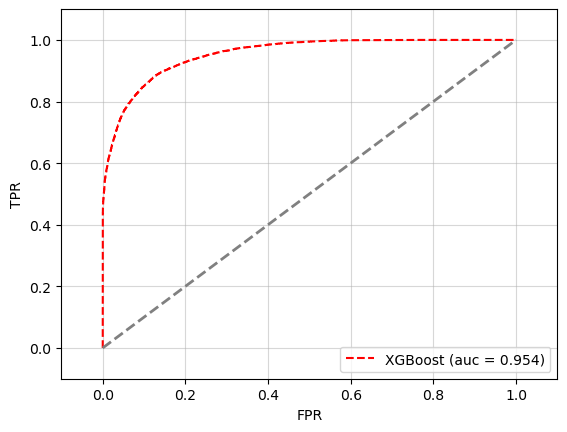

In [34]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr, 'r--', label='%s (auc = %0.3f)'%('XGBoost', roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

Train Accuracy: 0.9277246907681691
Test Accuracy: 0.8792058183362531
Train Precision: 0.9217974293744284
Test Precision: 0.8587305632360639
Train Recall: 0.8804710799661384
Test Recall: 0.8083772830082536
Train F1: 0.9006601627456343
Test F1: 0.8327851190381148


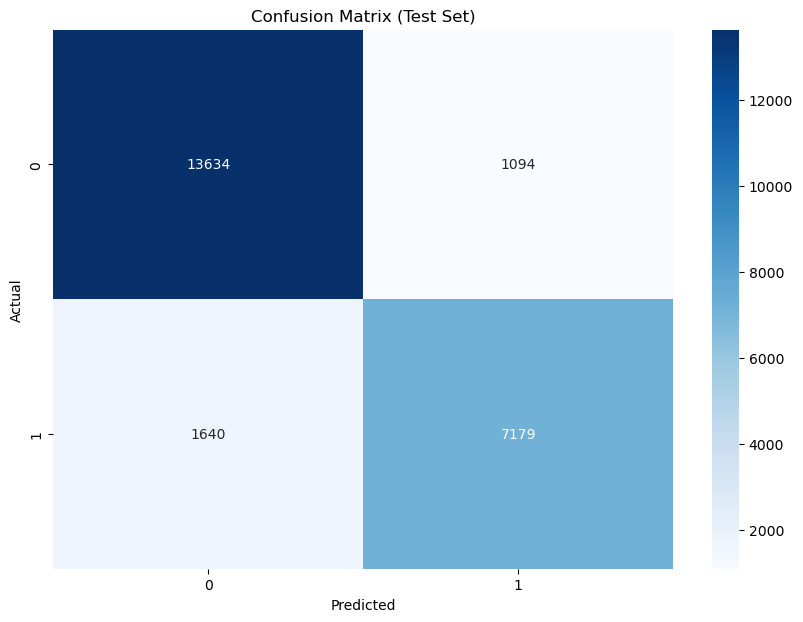

In [61]:
# 모델 설정
model = XGBClassifier(colsample_bytree=0.9, gamma=0.7, learning_rate=0.1,
                      max_depth=9, min_child_weight=3, n_estimators=300,
                      subsample=0.9)

# 교차 검증 및 점수 계산
cv = StratifiedKFold(shuffle=True, random_state=42)
score = cross_validate(model, X_train, y_train, scoring=scoring, return_train_score=True, cv=cv, n_jobs=-1)

print("Train Accuracy:", np.mean(score['train_accuracy']))
print("Test Accuracy:", np.mean(score['test_accuracy']))

print("Train Precision:", np.mean(score['train_precision']))
print("Test Precision:", np.mean(score['test_precision']))

print("Train Recall:", np.mean(score['train_recall']))
print("Test Recall:", np.mean(score['test_recall']))

print("Train F1:", np.mean(score['train_f1']))
print("Test F1:", np.mean(score['test_f1']))

# 테스트 세트에서 예측 수행
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# 혼동 행렬 계산 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

